In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [2]:
import torch.nn as nn
device = 'cpu'

In [3]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def fvec(self, t, x):
    return self.forward(x)

In [4]:
import time
input_size = 4
output_size = 4
hidden_size = 200

num_trials = 10

In [5]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

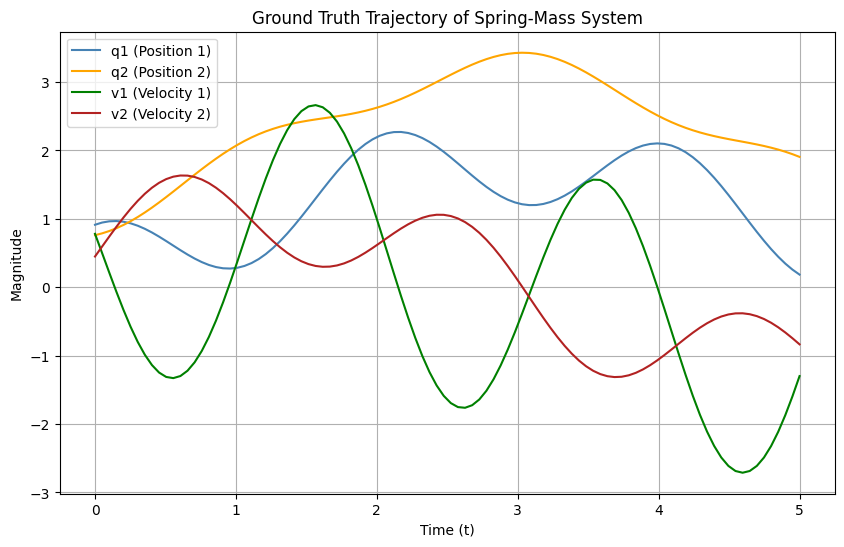

In [6]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']

  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  tval = sol['t']

  plt.figure(figsize=(10, 6))
  plt.plot(tval, q1, 'steelblue', label='q1 (Position 1)')
  plt.plot(tval, q2, 'orange', label='q2 (Position 2)')
  plt.plot(tval, v1, 'g', label='v1 (Velocity 1)')
  plt.plot(tval, v2, 'firebrick', label='v2 (Velocity 2)')
  plt.xlabel('Time (t)')
  plt.ylabel('Magnitude')
  plt.title('Ground Truth Trajectory of Spring-Mass System')
  plt.legend()
  plt.grid(True)
  plt.show()

In [7]:
true_res = []

for i in range(q1.shape[0]):
    true_res.append(np.array([q1[i], q2[i], v1[i], v2[i]]))

true_res = np.array(true_res)
print('true_res:', true_res.shape)

true_res: (100, 4)


In [8]:
import pandas as pd
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)
mlp_net = MLP(input_size, hidden_size, output_size).to(device)

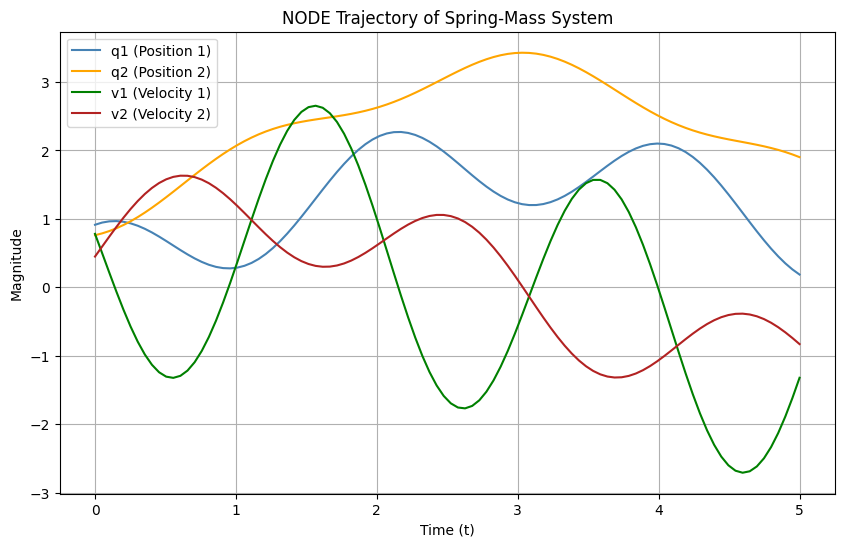

In [9]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

trial = 9

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

mlp_net.load_state_dict(torch.load("./model/node_ms_{}".format(trial), map_location="cpu"))
mlp_net.eval()
x0 = state[0]

A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mlp_net.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))
    output = mlp_net.forward(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)
    return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,t_eval)

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,res[:,1], 'orange', label='q2 (Position 2)')
plt.plot(t_eval,res[:,2], 'g', label='v1 (Velocity 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('NODE Trajectory of Spring-Mass System')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
def Hamiltonian_ftn(state):
    q1 = state[0]
    q2 = state[1]
    v1 = state[2]
    v2 = state[3]
    
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

def true_energy(trajectory):
    energies = []
    for state_t in trajectory:
        energies.append(Hamiltonian_ftn(state_t))

    return np.array(energies)

In [11]:
Htrue_node_x = true_energy(res).reshape((M))
Htrue_true_x = true_energy(true_res).reshape((M))

In [12]:
def plot_1x3_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_node_x):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    tpad = 7

     # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0].plot(t_eval, true_res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0].plot(t_eval, true_res[:, 1], 'orange', label='q2 (Position 2)')
    axes[0].plot(t_eval, true_res[:, 2], 'g', label='v1 (Velocity 1)')
    axes[0].plot(t_eval, true_res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0].set_ylabel('Magnitude')
    axes[0].set_xlabel('Time')
    axes[0].set_title('Ground Truth Trajectory')
    axes[0].legend(loc='upper right', fontsize=8)
    axes[0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[1].plot(t_eval, res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[1].plot(t_eval, res[:, 1], 'orange', label='q2 (Position 2)')
    axes[1].plot(t_eval, res[:, 2], 'g', label='v1 (Velocity 1)')
    axes[1].plot(t_eval, res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[1].set_ylabel('Magnitude')
    axes[1].set_xlabel('Time')
    axes[1].set_title('Trajectory Prediction by NODE')
    axes[1].legend(loc='upper right', fontsize=8)
    axes[1].grid(True)

    # --- Bottom Left Plot (0, 2): True Hamiltonian Perspective ---
    axes[2].plot(t_eval, Htrue_true_x, 'k-', label='H_true(true_u)', linewidth=2)
    axes[2].plot(t_eval, Htrue_node_x, 'b--', label='H_true(node_u)', linewidth=2)
    axes[2].set_title("True Hamiltonian (u)", pad=tpad)
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Energy H(u)')
    axes[2].legend(fontsize=8)
    axes[2].grid(True)



    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/node_asis_eval_figure_1x3_by_danieljh.png", dpi=150) # PNG 파일로 저장
    plt.show()


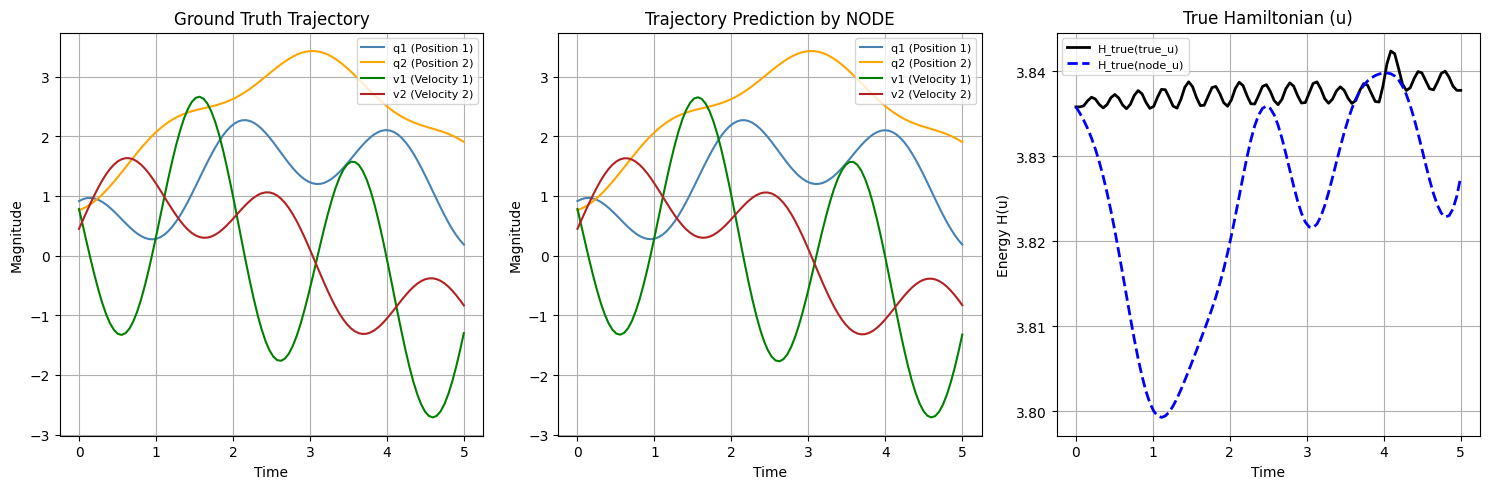

In [13]:
plot_1x3_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_node_x)

In [14]:
def plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_node_x):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_res[:, 1], 'orange', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_res[:, 2], 'g', label='v1 (Velocity 1)')
    axes[0, 0].plot(t_eval, true_res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_title('Ground Truth Trajectory')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, res[:, 1], 'orange', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, res[:, 2], 'g', label='v1 (Velocity 1)')
    axes[0, 1].plot(t_eval, res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_title('Trajectory Prediction by Neural ODE (NODE)')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x, 'k-', label='H_true(true_u)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_node_x, 'b--', label='H_true(NODE_u)', linewidth=2)
    axes[1, 0].set_title("True Energy (u)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Energy E(u)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/node_asis_eval_figure_2x2_by_danieljh.png", dpi=150) # PNG 파일로 저장
    plt.show()

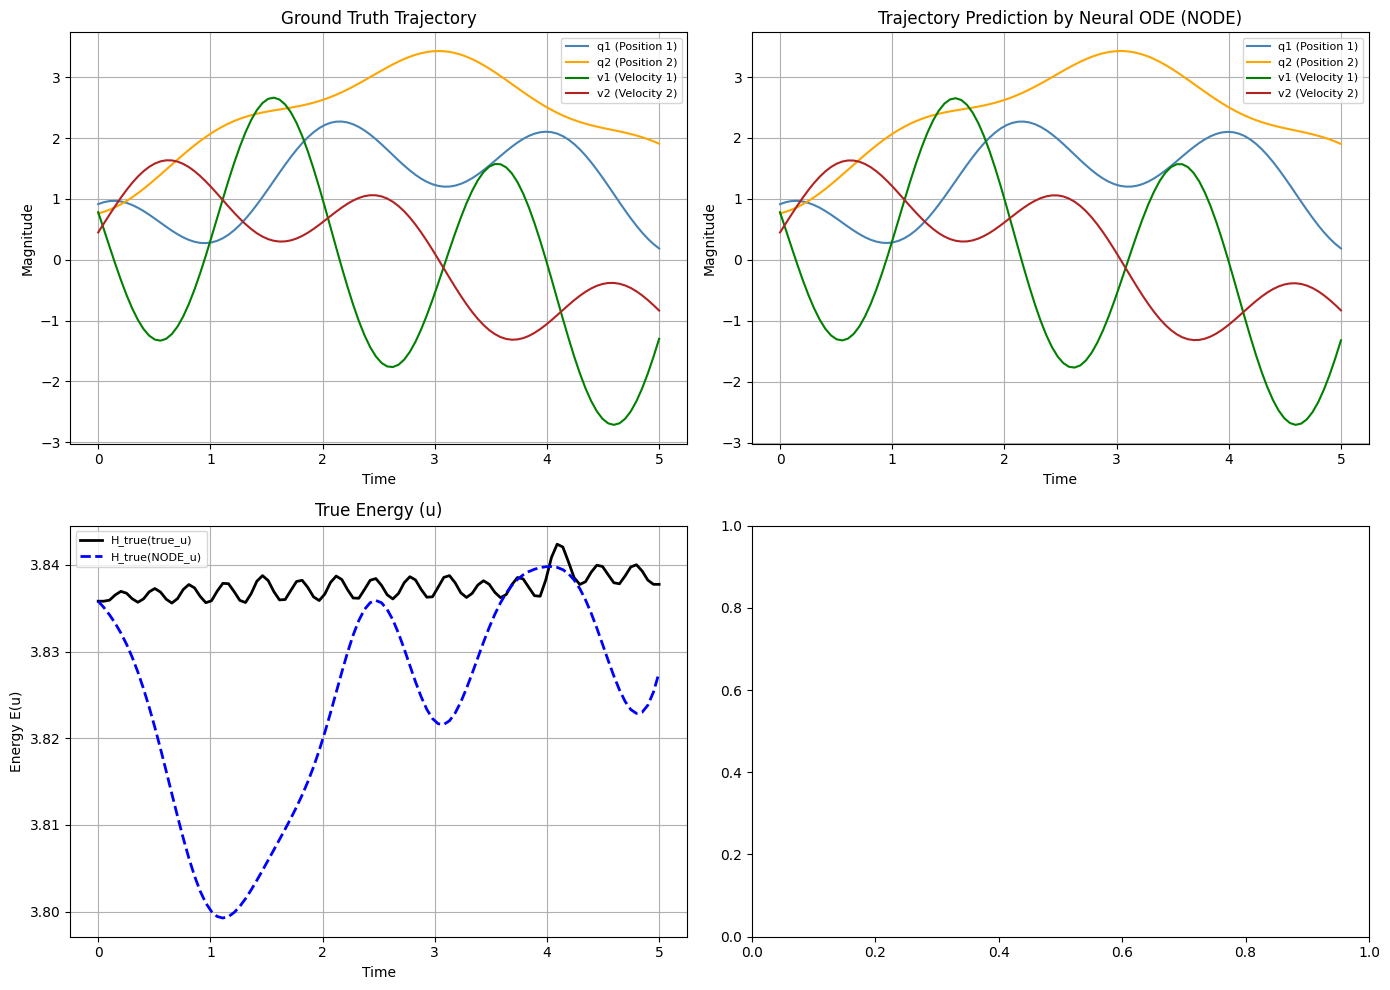

In [15]:
plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_node_x)